# カーネルパラの最尤推定
- RBFカーネルのスケールパラメータを勾配降下法を使ってデータから最尤推定する

In [1]:
import numpy as np
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import japanize_matplotlib

In [2]:
# トイデータ生成
N = 20
x_data = np.random.uniform(-1, 1, N)

def true_func(x):
    return 2*np.exp(x) * np.sin(2*np.pi * x)

y_data = true_func(x_data) - 0.2 + np.random.randn(N)

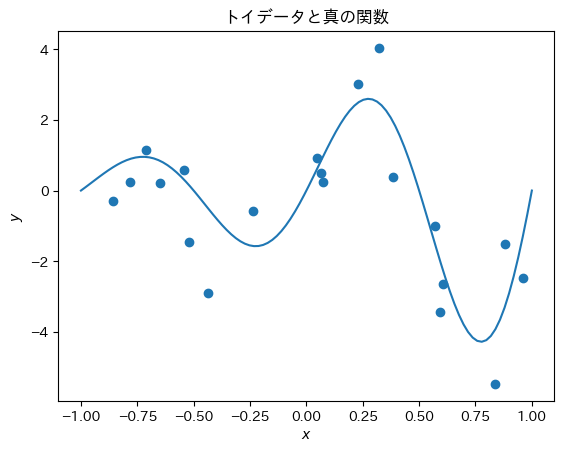

In [153]:
plt.scatter(x_data, y_data)
tmp = np.linspace(-1,1,100)
plt.plot(tmp, true_func(tmp))
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("トイデータと真の関数");

In [154]:
# RBFカーネル
def rbf_kernel(scale, x, x_p):
    return jnp.exp(-(jnp.linalg.norm(x-x_p)**2)/scale)

In [155]:
def make_K(datas, sigma, scale):
    matK = jnp.zeros((len(datas), len(datas)))
    for x_idx, xd in enumerate(datas):
        for xp_idx, xpd in enumerate(datas):
            if(x_idx == xp_idx):
                matK = matK.at[x_idx, xp_idx].set(sigma + rbf_kernel(scale, xd, xpd))
            else:
                matK = matK.at[x_idx, xp_idx].set(rbf_kernel(scale, xd, xpd))
    return matK

def make_k_vec(datas, x, scale):
    k_vec = jnp.zeros(len(datas))
    for idx, d in enumerate(datas):
        k_vec = k_vec.at[idx].set(rbf_kernel(scale, d, x))
    return k_vec

In [156]:
def GP_reg_model(x_pred, x_data, y_data, sigma, scale):
    K_inv = jnp.linalg.inv(make_K(x_data, sigma, scale))
    k_vec = make_k_vec(x_data, x_pred, scale)
    tmp = k_vec @ K_inv
    y_pred = tmp @ y_data.T
    var = rbf_kernel(scale, x_pred, x_pred) + sigma - tmp @ k_vec.T
    return y_pred, var

In [161]:
def loss_func(scale, x_data, y_data, sigma):
    y_pred = jnp.zeros(len(x_data))
    for n, x in enumerate(x_data):
        pred, _ = GP_reg_model(x, x_data, y_data, sigma, scale)
        y_pred = y_pred.at[n].set(pred)
    return jnp.mean((y_pred - y_data)**2)

In [189]:
def update(scale, x_data, y_data, sigma, lr, isReturnLoss=True):
    loss = None
    if(scale - lr * jax.grad(loss_func)(scale, x_data, y_data, sigma) > 0):
        new_scale = scale - lr * jax.grad(loss_func)(scale, x_data, y_data, sigma)
    else:
        new_scale = scale - lr * (1/1000) * jax.grad(loss_func)(scale, x_data, y_data, sigma)
        
    if(isReturnLoss):
        loss = loss_func(new_scale, x_data, y_data, sigma)
    return new_scale, loss

In [196]:
scale = 0.1# ハイパラの初期値
sigma = 0.1

In [191]:
# ハイパラ学習前の推定
x_pred = jnp.linspace(-1, 1, 100)
y_pred = jnp.zeros(len(x_pred))
y_std = jnp.zeros(len(x_pred))

for n, x_p in enumerate(x_pred):
    pred, var = GP_reg_model(x_p, x_data, y_data, sigma, scale)
    y_pred = y_pred.at[n].set(pred)
    y_std = y_std.at[n].set(jnp.sqrt(var))

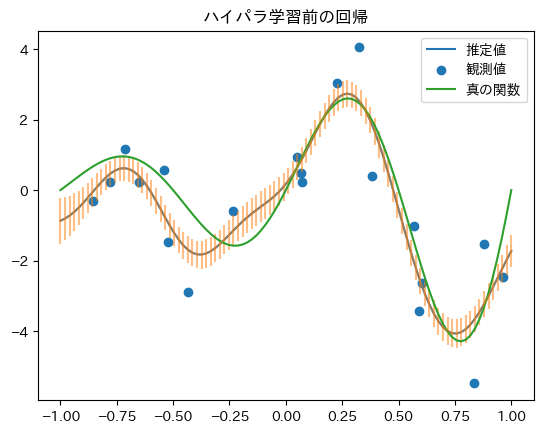

In [192]:
plt.plot(x_pred, y_pred, label="推定値")
plt.errorbar(x_pred, y_pred, y_std, alpha=0.5)
plt.scatter(x_data, y_data, label="観測値")
tmp = np.linspace(-1,1,100)
plt.plot(tmp, true_func(tmp), label="真の関数")
plt.title("ハイパラ学習前の回帰")
plt.legend();

In [197]:
# ハイパラの学習
lr=0.005
learning_step = 20


x_data = jnp.array(x_data)
y_data = jnp.array(y_data)
loss_histry = []

for t in range(learning_step):
    print("step:{}".format(t+1))
    scale, loss = update(scale, x_data, y_data, sigma, lr)
    print("loss:{}".format(loss))
    print("scale:{}".format(scale))
    loss_histry.append(loss)
    print("--------------------")

step:1
loss:0.8382279276847839
scale:0.08602157980203629
--------------------
step:2
loss:0.787520170211792
scale:0.07057370245456696
--------------------
step:3
loss:0.7213951349258423
scale:0.053164832293987274
--------------------
step:4
loss:0.5926690101623535
scale:0.03180709481239319
--------------------
step:5
loss:0.5922788977622986
scale:0.03176295384764671
--------------------
step:6
loss:0.5918877124786377
scale:0.03171873092651367
--------------------
step:7
loss:0.5914949774742126
scale:0.03167442977428436
--------------------
step:8
loss:0.5911006927490234
scale:0.03163004666566849
--------------------
step:9
loss:0.5907047390937805
scale:0.031585581600666046
--------------------
step:10
loss:0.5903078317642212
scale:0.03154103457927704
--------------------
step:11
loss:0.5899084210395813
scale:0.031496405601501465
--------------------
step:12
loss:0.5895089507102966
scale:0.031451694667339325
--------------------
step:13
loss:0.5891062617301941
scale:0.03140690177679062


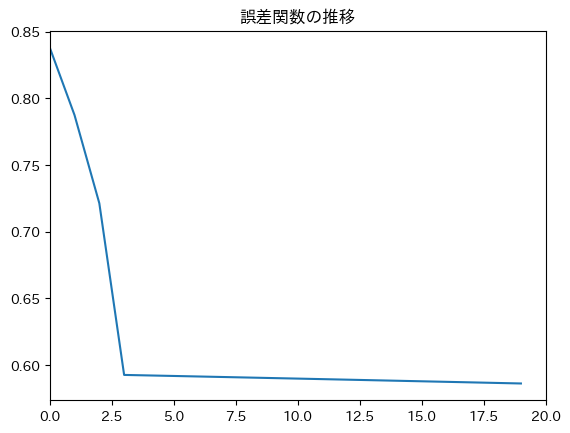

In [209]:
plt.plot(range(len(loss_histry)), loss_histry)
plt.xlim(0, len(loss_histry))
plt.title("誤差関数の推移");

In [198]:
# ハイパラ学習後の推定
x_pred = jnp.linspace(-1, 1, 100)
y_pred = jnp.zeros(len(x_pred))
y_std = jnp.zeros(len(x_pred))

for n, x_p in enumerate(x_pred):
    pred, var = GP_reg_model(x_p, x_data, y_data, sigma, scale)
    y_pred = y_pred.at[n].set(pred)
    y_std = y_std.at[n].set(jnp.sqrt(var))

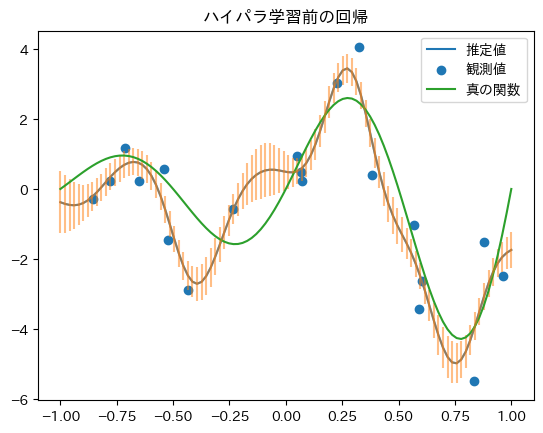

In [199]:
plt.plot(x_pred, y_pred, label="推定値")
plt.errorbar(x_pred, y_pred, y_std, alpha=0.5)
plt.scatter(x_data, y_data, label="観測値")
tmp = np.linspace(-1,1,100)
plt.plot(tmp, true_func(tmp), label="真の関数")
plt.title("ハイパラ学習前の回帰")
plt.legend();

## jaxの自動微分の練習

In [105]:
def test_func_1(x1):
    return x1**2 + x1*3 + 4

def test_func_2(x1, x2):
    return x1**2 + x1*x2 + x2 + 4

def test_func_3(x1, x2):
    return jnp.sum(x1**2 + x1*x2 + x2 +4)

In [106]:
func_grad = jax.grad(test_func_1)

In [107]:
func_grad(1.0)

DeviceArray(5., dtype=float32, weak_type=True)

In [108]:
jax.grad(test_func_2)(1.0, 2.0)

DeviceArray(4., dtype=float32, weak_type=True)

In [109]:
jax.grad(test_func_2, argnums=(0, 1))(1.0, 2.0) #第１、２引数の偏微分をそれぞれ計算

(DeviceArray(4., dtype=float32, weak_type=True),
 DeviceArray(2., dtype=float32, weak_type=True))

In [113]:
#複数データ一度に流す
# 元々の関数を多入力対応させておく
x = jnp.asarray([[1.0,2.0,3.0]])
jax.grad(test_func_3)(x, 2*x)

DeviceArray([[ 4.,  8., 12.]], dtype=float32)